In [1]:
# SKIP THIS IF YOU WANT TO USE THE NON WEB INTERFACE (can only be done when notebook run locally)
%matplotlib inline

In [2]:
#%%
try:
    get_ipython().magic(u'load_ext autoreload')
    get_ipython().magic(u'autoreload 2')
    print(1)
except:
    print('NOT IPYTHON')

import sys
import numpy as np
import tifffile
import psutil
from scipy.ndimage.filters import gaussian_filter
from ipyparallel import Client

import caiman as cm
from caiman.utils.visualization import nb_view_patches3d
import caiman.source_extraction.cnmf as cnmf
from caiman.source_extraction.cnmf.utilities import order_components

import matplotlib.pyplot as plt
import bokeh.plotting as bpl
bpl.output_notebook()

1


Loading BokehJS ...

In [3]:
#%%
n_processes = psutil.cpu_count()
print('using ' + str(n_processes) + ' processes')
print("Stopping  cluster to avoid unnencessary use of memory....")
sys.stdout.flush()  
cm.stop_server()

using 4 processes
Stopping  cluster to avoid unnencessary use of memory....
Stopping cluster...
NOT SLURM
Waiting for cluster to stop....... done


In [4]:
def gen_data(p = 1, noise=1., T=256, framerate=30, firerate=2., plot=False):
    if p==2:
        gamma = np.array([1.5,-.55])
    elif p==1:
        gamma = np.array([.9])
    else: raise
    dims = (30, 40, 50)  # size of image
    sig = (2, 2, 2)  # neurons size
    bkgrd = 10
    N = 20  # number of neurons
    np.random.seed(7)
    centers = np.asarray([[np.random.randint(5,x-5) 
                           for x in dims] for i in range(N)])
    Yr = np.zeros(dims + (T,), dtype=np.float32)
    trueSpikes = np.random.rand(N,T) < firerate / float(framerate)
    trueSpikes[:,0] = 0
    truth = trueSpikes.astype(np.float32)
    for i in range(2,T):
        if p ==2:
            truth[:,i] += gamma[0]*truth[:,i-1] + gamma[1]*truth[:,i-2] 
        else:
            truth[:,i] += gamma[0]*truth[:,i-1]
    for i in range(N):
        Yr[centers[i,0],centers[i,1],centers[i,2]] = truth[i]
    tmp=np.zeros(dims)
    tmp[15,20,25]=1.
    z=np.linalg.norm(gaussian_filter(tmp, sig).ravel())
    Yr = bkgrd + noise * np.random.randn(*(dims + (T,))) + 10 *gaussian_filter(Yr, sig + (0,)) /z
    d1,d2,d3,T=Yr.shape
    Yr=np.reshape(Yr,(d1*d2*d3,T),order='F').astype(np.float32)
 
    if plot:
        Y=np.reshape(Yr,(d1,d2,d3,T),order='F')
        plt.figure(figsize=(15,3))
        plt.plot(truth.T);
        plt.figure(figsize=(15,3))
        for c in centers:
            plt.plot(Y[c[0],c[1],c[2]]);

        plt.figure(figsize=(15,4))
        plt.subplot(131)
        plt.scatter(*centers.T[::-1],c='g')
        plt.imshow(Y.max(0).max(-1),cmap='hot');plt.title('Max.proj. x & t')
        plt.subplot(132)
        plt.scatter(*centers.T[[2,0,1]],c='g')
        plt.imshow(Y.max(1).max(-1),cmap='hot');plt.title('Max.proj. y & t')
        plt.subplot(133)
        plt.scatter(*centers.T[[1,0,2]],c='g')
        plt.imshow(Y.max(2).max(-1),cmap='hot');plt.title('Max.proj. z & t')
        plt.show()
        
    return Yr, truth, trueSpikes, centers, dims

In [5]:
plt.close('all')
#%% SAVING TIFF FILE ON A SINGLE MEMORY MAPPABLE FILE
try:
    fname_new=cm.save_memmap(['example_movies/demoMovie3D.tif'],base_name='Yr',is_3D=True)
except: #%% create 3d tiff file if not yet existent
    Yr, truth, trueSpikes, centers, dims = gen_data(p=2)
    # imagej takes data shapes up to 6 dimensions in TZCYXS order
    data = np.transpose(Yr.reshape(dims+(-1,1), order='F'), [3, 0, 4, 1, 2])
    t = tifffile.TiffWriter('example_movies/demoMovie3D.tif', imagej=True)
    t.save(data)
    t.close()
    fname_new=cm.save_memmap(['example_movies/demoMovie3D.tif'],base_name='Yr',is_3D=True)

print(fname_new)

example_movies/demoMovie3D.tif
example_movies/Yr_d1_30_d2_40_d3_50_order_F_frames_256_.mmap


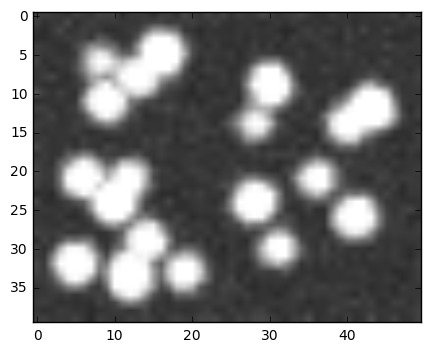

In [6]:
Yr,dims,T=cm.load_memmap(fname_new)
Y=np.reshape(Yr,dims+(T,),order='F')
Cn = cm.local_correlations(Y)
plt.imshow(Cn.max(0) if len(Cn.shape)==3 else Cn, cmap='gray',
           vmin=np.percentile(Cn, 1), vmax=np.percentile(Cn, 99))    
plt.show()

In [7]:
# set parameters
K=20 # number of neurons expected per patch
gSig=[2,2,2] # expected half size of neurons
merge_thresh=0.8 # merging threshold, max correlation allowed
p=2 #order of the autoregressive system

In [8]:
# START CLUSTER
cm.start_server()
c=Client()

Starting cluster...Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
......

In [9]:
# INIT
cnm = cnmf.CNMF(n_processes, method_init='greedy_roi', k=K, gSig=gSig, merge_thresh=merge_thresh,
                p=p, dview=None, Ain=None, method_deconvolution='oasis')

In [10]:
# FIT
images = np.reshape(Yr.T, [T] + list(dims), order='F')
cnm = cnm.fit(images)

(256, 30, 40, 50)
using 4 processes
using 4000 pixels per process
using 20000 block_size
preprocessing ...
checking if missing data
Single Thread
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
initializing ...
Noise Normalization
Spatial Downsampling ...
Roi Extraction...
Refining Components...
update spatial ...
found spatial support for each component
(60000, 20)
Starting Update Spatial Components
updating lars
clearing variables
done!
updating lars
clearing variables
done!
updating lars
clearing variables
done!
updating lars
clearing variables
done!
updating lars
clearing variables
done!
updating lars
clearing variables
done!
updating lars
clearing variables
done!
updating lars
clearing variables
done!
updating lars
clearing variables
done!
updating lars
clearing variables
done!
updating lars
clearing variables
done!
updating lars
clearing variables
done!
updating lars
clearing variables
done!
updating lars
clearing variables
done!
updating lars
clearing 

In [11]:
A_or, C_or, srt = order_components(cnm.A,cnm.C)

In [12]:
# view patches per layer
traces_fluo=nb_view_patches3d(Yr, A_or, C_or, cnm.b, cnm.f, dims, image_type='max',
                              max_projection=False,thr = 0.9)

Loading BokehJS ...

## Run patches 

In [11]:
rf = (15,15,15)  # half-size of the patches in pixels. rf=25, patches are 50x50
stride = (10,10,10)  # amounpl.it of overlap between the patches in pixels
K = 12  # number of neurons expected per patch
gSig = [2,2,2]  # expected half size of neurons
merge_thresh = 0.8  # merging threshold, max correlation allowed
p = 1  # order of the autoregressive system
save_results = False
#%% RUN ALGORITHM ON PATCHES
init_method = 'greedy_roi'
alpha_snmf=None #10e2  # this controls sparsity

cnm = cnmf.CNMF(n_processes, k=K, gSig=gSig, merge_thresh=0.8, p=0, dview=c[:], Ain=None, rf=rf, stride=stride, memory_fact=1,
                method_init=init_method, alpha_snmf=alpha_snmf, only_init_patch=True, gnb=1,method_deconvolution='oasis')
cnm = cnm.fit(images)

A_tot = cnm.A
C_tot = cnm.C
YrA_tot = cnm.YrA
b_tot = cnm.b
f_tot = cnm.f
sn_tot = cnm.sn

print(('Number of components:' + str(A_tot.shape[-1])))

(256, 30, 40, 50)
using 4 processes
using 4000 pixels per process
using 20000 block_size
*
[30, 31, 31]
[30, 31, 30]
[30, 30, 31]
[30, 30, 30]
You may think that it went well but reality is harsh
6.17382216454
Transforming patches into full matrix


/Users/joe/anaconda2/lib/python2.7/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Generating background
using 4 processes
using 4000 pixels per process
using 20000 block_size
merging
[ 4 15 22 30 38]
[ 7 14 23 35 45]
[13 21 37 47]
[10 18 34 44]
[12 20 36 46]
[ 0 24]
[ 2 28]
[ 8 33]
[17 40]
[16 39]
[ 5 31]
[ 6 29]
[19 41]
[32 43]
[11 27]
********** No neurons merged! ***************
update temporal
Generating residuals
Forcing single thread for memory issues
parallel dot product block size: 20000
Start product
Transposing
19999
39999
59999
Done
1 out of total 21 temporal components updated
5 out of total 21 temporal components updated
8 out of total 21 temporal components updated
12 out of total 21 temporal components updated
16 out of total 21 temporal components updated
21 out of total 21 temporal components updated
3 out of total 21 temporal components updated
9 out of total 21 temporal components updated
13 out of total 21 temporal components updated
17 out of total 21 temporal components updated
21 out of total 21 temporal components updated
stopping: overall te

In [12]:
cnm = cnmf.CNMF(n_processes, k=A_tot.shape, gSig=gSig, merge_thresh=merge_thresh, p=p, dview=c[:], Ain=A_tot, Cin=C_tot,
                    f_in=f_tot, rf=None, stride=None, method_deconvolution='oasis')
cnm = cnm.fit(images)

(256, 30, 40, 50)
using 4 processes
using 4000 pixels per process
using 20000 block_size
preprocessing ...
checking if missing data
Running on 4 engines.
update spatial ...
found spatial support for each component
(60000, 21)
Starting Update Spatial Components
Updated Spatial Components
threshold
Computing residuals
parallel dot product block size: 1000
Start product
Filling
Computing A_bas
--- 14.9293239117 seconds ---
Remove temporary file created
update temporal ...
Generating residuals
Forcing single thread for memory issues
parallel dot product block size: 20000
Start product
Transposing
19999
39999
59999
Done
4 out of total 21 temporal components updated
13 out of total 21 temporal components updated
21 out of total 21 temporal components updated
1 out of total 21 temporal components updated
5 out of total 21 temporal components updated
13 out of total 21 temporal components updated
21 out of total 21 temporal components updated
stopping: overall temporal component not changing s

In [13]:
from caiman.components_evaluation import evaluate_components
final_frate = 10# approx final rate  (after eventual downsampling )
Npeaks = 10
traces = C_tot + YrA_tot
#        traces_a=traces-scipy.ndimage.percentile_filter(traces,8,size=[1,np.shape(traces)[-1]/5])
#        traces_b=np.diff(traces,axis=1)
fitness_raw, fitness_delta, erfc_raw, erfc_delta, r_values, significant_samples = evaluate_components(
Y, traces, A_tot, C_tot, b_tot, f_tot, final_frate, remove_baseline=True, N=5, robust_std=False, Athresh=0.1, Npeaks=Npeaks,  thresh_C=0.3)

idx_components_r = np.where(r_values >= .5)[0]
idx_components_raw = np.where(fitness_raw < -40)[0]
idx_components_delta = np.where(fitness_delta < -20)[0]

idx_components = np.union1d(idx_components_r, idx_components_raw)
idx_components = np.union1d(idx_components, idx_components_delta)
idx_components_bad = np.setdiff1d(list(range(len(traces))), idx_components)

print(('Keeping ' + str(len(idx_components)) +
   ' and discarding  ' + str(len(idx_components_bad))))

ValueError: too many values to unpack

In [ ]:
A_or, C_or, srt = order_components(cnm.A,cnm.C)

In [ ]:
# view patches per layer
traces_fluo=nb_view_patches3d(Yr, A_or, C_or, cnm.b, cnm.f, dims, image_type='max',
                              max_projection=False,thr = 0.9)

In [ ]:
# view patches as maximum-projection
traces_fluo=nb_view_patches3d(Yr, A_or, C_or, cnm.b, cnm.f, dims, image_type='mean',
                              max_projection=True,axis=0,denoised_color='red')

In [ ]:
# STOP CLUSTER
cm.stop_server()